In [1]:
#installing and importing dependencies
!pip install opencv-python matplotlib imageio gdown 
!pip install tensorflow==2.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-est

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.1
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
catalogue                     2.0.8
certifi                       2022.12.7


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt 
import imageio

In [4]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
#to prevent sucking up the memory
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

Build Data Loading Functions

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
import gdown

In [7]:
# !unzip /content/drive/MyDrive/data.zip
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:05<00:00, 81.5MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str) -> List[float]: #taking datapath amd output video as float

    cap = cv2.VideoCapture(path)#takes path
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): #looping through frame and storing in frames array
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)#to have less data to preprocess
        frames.append(frame[190:236,80:220,:])#isolating mouth area using static slicing fn
    cap.release()
    #standardizing the data
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()


['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['a','b','c'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [14]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'


In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]


'bbal6n'

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


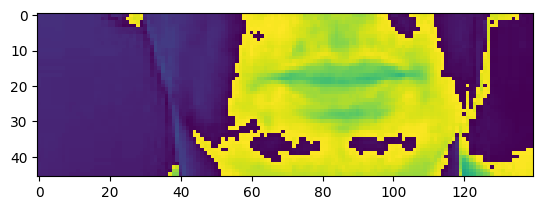

In [18]:
plt.imshow(frames[3])


In [19]:
alignments


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

Create Data Pipeline

In [22]:
from matplotlib import pyplot as plt


In [23]:
# data = tf.io.gfile.listdir('/content/data/s1/')
data = [f for f in tf.io.gfile.listdir('/content/data/s1/') if f.endswith('.mpg')]

print(data)
data=tf.data.experimental.from_list(
    data, name=None
)
print(data)
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))#1 frame includes 2 videos and 2 alignments and esch video have 75 frames
data = data.prefetch(tf.data.AUTOTUNE)#to ensure that we are optimizing data pipeline 
# Added for split 
train = data.take(450)
test = data.skip(450)

['pbbp4p.mpg', 'priv5s.mpg', 'bbil4p.mpg', 'bgaa8p.mpg', 'sbaa7a.mpg', 'sbag9s.mpg', 'bgwb7a.mpg', 'bwbt8p.mpg', 'briz7s.mpg', 'srbb5s.mpg', 'sgav7a.mpg', 'lwal5a.mpg', 'sbiazn.mpg', 'bwba5s.mpg', 'bwbn2n.mpg', 'sbwu5s.mpg', 'srau3s.mpg', 'lbwe4n.mpg', 'bwba7a.mpg', 'pwip7s.mpg', 'pbwc8n.mpg', 'bbal9a.mpg', 'sbig5s.mpg', 'prbx5a.mpg', 'pwbq6p.mpg', 'srbo3s.mpg', 'lwwm3a.mpg', 'pwbd6n.mpg', 'swavzp.mpg', 'pbwdzp.mpg', 'prav9s.mpg', 'bwaa2p.mpg', 'lbwr2n.mpg', 'lbij6n.mpg', 'bris5a.mpg', 'pwip8p.mpg', 'prwd6p.mpg', 'srao1a.mpg', 'lwik9s.mpg', 'pbii1s.mpg', 'sbig6p.mpg', 'pwaq1s.mpg', 'lwwf6n.mpg', 'lbbk6p.mpg', 'bwam9s.mpg', 'lwbz7a.mpg', 'bwwh5a.mpg', 'bgan5s.mpg', 'bbbm2p.mpg', 'lbby5a.mpg', 'prip1s.mpg', 'lbbq8n.mpg', 'bbwg2p.mpg', 'pwbyzp.mpg', 'sgbp6p.mpg', 'bwim7a.mpg', 'srwb8n.mpg', 'pwwezn.mpg', 'bwwa9s.mpg', 'pgwe7s.mpg', 'pgid5s.mpg', 'swbi6p.mpg', 'lrarzn.mpg', 'lwal4p.mpg', 'bgbu3s.mpg', 'bbas3a.mpg', 'srin5s.mpg', 'sbbn7s.mpg', 'pwbq4n.mpg', 'bgit5s.mpg', 'sbit5a.mpg', 'bgia

In [24]:
frames, alignments = data.as_numpy_iterator().next()


In [25]:
frames

array([[[[[ 1.4638735 ],
          [ 1.4638735 ],
          [ 1.4638735 ],
          ...,
          [ 0.2373849 ],
          [ 0.2373849 ],
          [ 0.15825659]],

         [[ 1.4638735 ],
          [ 1.4638735 ],
          [ 1.4638735 ],
          ...,
          [ 0.2373849 ],
          [ 0.2373849 ],
          [ 0.15825659]],

         [[ 1.4638735 ],
          [ 1.4638735 ],
          [ 1.4243094 ],
          ...,
          [ 0.2373849 ],
          [ 0.2373849 ],
          [ 0.2373849 ]],

         ...,

         [[ 0.98910373],
          [ 0.98910373],
          [ 0.98910373],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.98910373],
          [ 0.98910373],
          [ 0.98910373],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.98910373],
          [ 0.98910373],
          [ 0.98910373],
          ...,
          [ 0.        ],
          [ 0.        ],
          

In [26]:
len(frames)


2

In [27]:
sample = data.as_numpy_iterator()


In [28]:
val = sample.next(); val[0]


array([[[[[ 1.4638735 ],
          [ 1.4638735 ],
          [ 1.4638735 ],
          ...,
          [ 0.2373849 ],
          [ 0.2373849 ],
          [ 0.15825659]],

         [[ 1.4638735 ],
          [ 1.4638735 ],
          [ 1.4638735 ],
          ...,
          [ 0.2373849 ],
          [ 0.2373849 ],
          [ 0.15825659]],

         [[ 1.4638735 ],
          [ 1.4638735 ],
          [ 1.4243094 ],
          ...,
          [ 0.2373849 ],
          [ 0.2373849 ],
          [ 0.2373849 ]],

         ...,

         [[ 0.98910373],
          [ 0.98910373],
          [ 0.98910373],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.98910373],
          [ 0.98910373],
          [ 0.98910373],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.98910373],
          [ 0.98910373],
          [ 0.98910373],
          ...,
          [ 0.        ],
          [ 0.        ],
          

In [29]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)


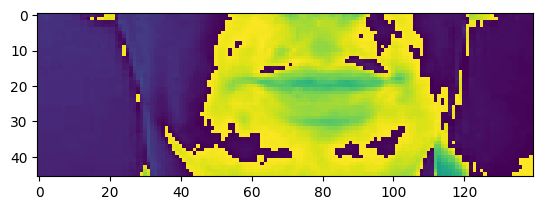

In [30]:
plt.imshow(val[0][0][35])


In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red by o three soon'>

Design the Deep Neural Network

In [32]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
#neural network
model = Sequential() #taking max values in each frame and condense it down into 2-2 sqaure 
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))#allow us to have 75 inputs into lstm

#2 lstm layers
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [36]:
yhat = model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [37]:
#returning back what our model is predicting
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'mmmmmmmmmmmmmmmjjjjjjjjjjjjjjjjjjjjjjjjjjmmmmmmmmmmmmmmmmmmmjjjjjjmvvvvvvvv'>

In [38]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'mmmmmmmmmmmmmmmjjjjjjjjjjjjjjjjjjjjjjjjjjmmmmmmmmmmmmmmmmmmmjjjjjjmvvvvvvvv'>

setup training options and train

In [39]:
#defining learning rate schedular
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)


In [40]:
#redefining our CTC loss
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [41]:
#outputting set od predictions
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()#to decode the ouput of ctc trained model
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

defining ou callbacks

In [43]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [44]:
schedule_callback = LearningRateScheduler(scheduler)

In [45]:
example_callback = ProduceExample(test)

In [46]:
model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/10
1/1 [==============================] - 3s 3s/step
Original: bin green in t four now
Prediction: le e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at t five again
Prediction: le e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 980s 2s/step - loss: 83.3254 - val_loss: 69.5447 - lr: 1.0000e-04
Epoch 2/10
1/1 [==============================] - 0s 231ms/step
Original: set blue at a six please
Prediction: la e e e e en
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white at j nine again
Prediction: la e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 726s 2s/step - loss: 70.4683 - val_loss: 65.7831 - lr: 1.0000e-04
Epoch 3/10

KeyboardInterrupt: ignored

Make prediction

In [61]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 189MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [62]:
model.load_weights('models/checkpoint') 

In [63]:
test_data = test.as_numpy_iterator()

In [64]:
test_data.next()

(array([[[[[1.3478067 ],
           [1.3478067 ],
           [1.3478067 ],
           ...,
           [8.985378  ],
           [9.397207  ],
           [0.        ]],
 
          [[1.3478067 ],
           [1.3478067 ],
           [1.3478067 ],
           ...,
           [9.135134  ],
           [9.472086  ],
           [9.434647  ]],
 
          [[1.2729285 ],
           [1.2729285 ],
           [1.2729285 ],
           ...,
           [0.07487815],
           [0.11231723],
           [0.11231723]],
 
          ...,
 
          [[0.93597686],
           [0.93597686],
           [0.93597686],
           ...,
           [9.472086  ],
           [9.509525  ],
           [9.509525  ]],
 
          [[0.93597686],
           [0.93597686],
           [0.93597686],
           ...,
           [9.434647  ],
           [9.434647  ],
           [9.434647  ]],
 
          [[0.93597686],
           [0.93597686],
           [0.93597686],
           ...,
           [9.434647  ],
           [9.434647  

In [65]:
sample = test_data.next()

In [66]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 237ms/step


In [67]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue at a six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white at j nine again'>]

In [68]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [69]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue at a six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white at j nine again'>]

Testing on video

In [70]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [71]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [72]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [73]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [74]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]